# 1.Importación librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Importación fuente de datos

In [2]:
df = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Visualizacion

# Analisis univariado

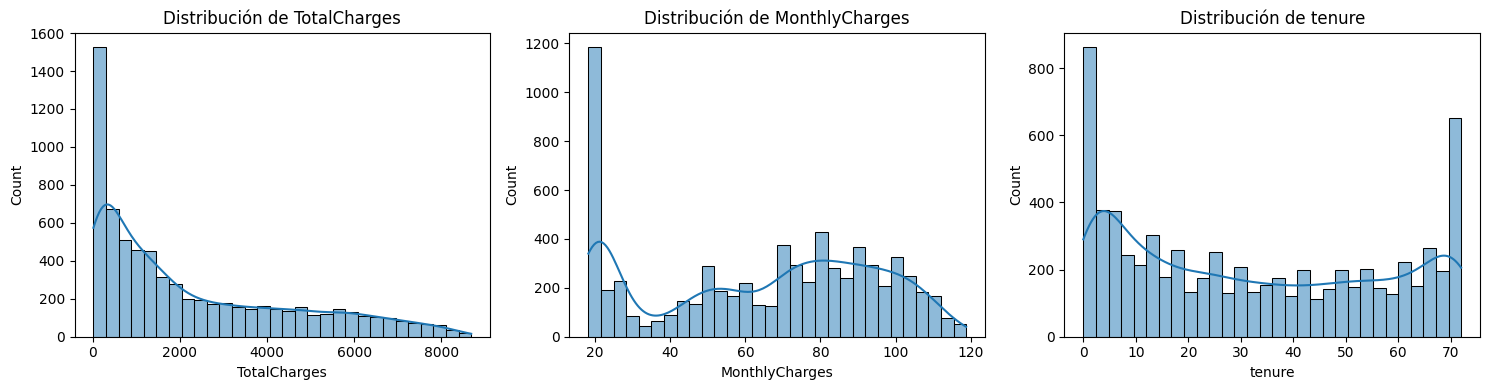

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(['TotalCharges', 'MonthlyCharges', 'tenure']):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')

plt.tight_layout()

# Variables categoricas

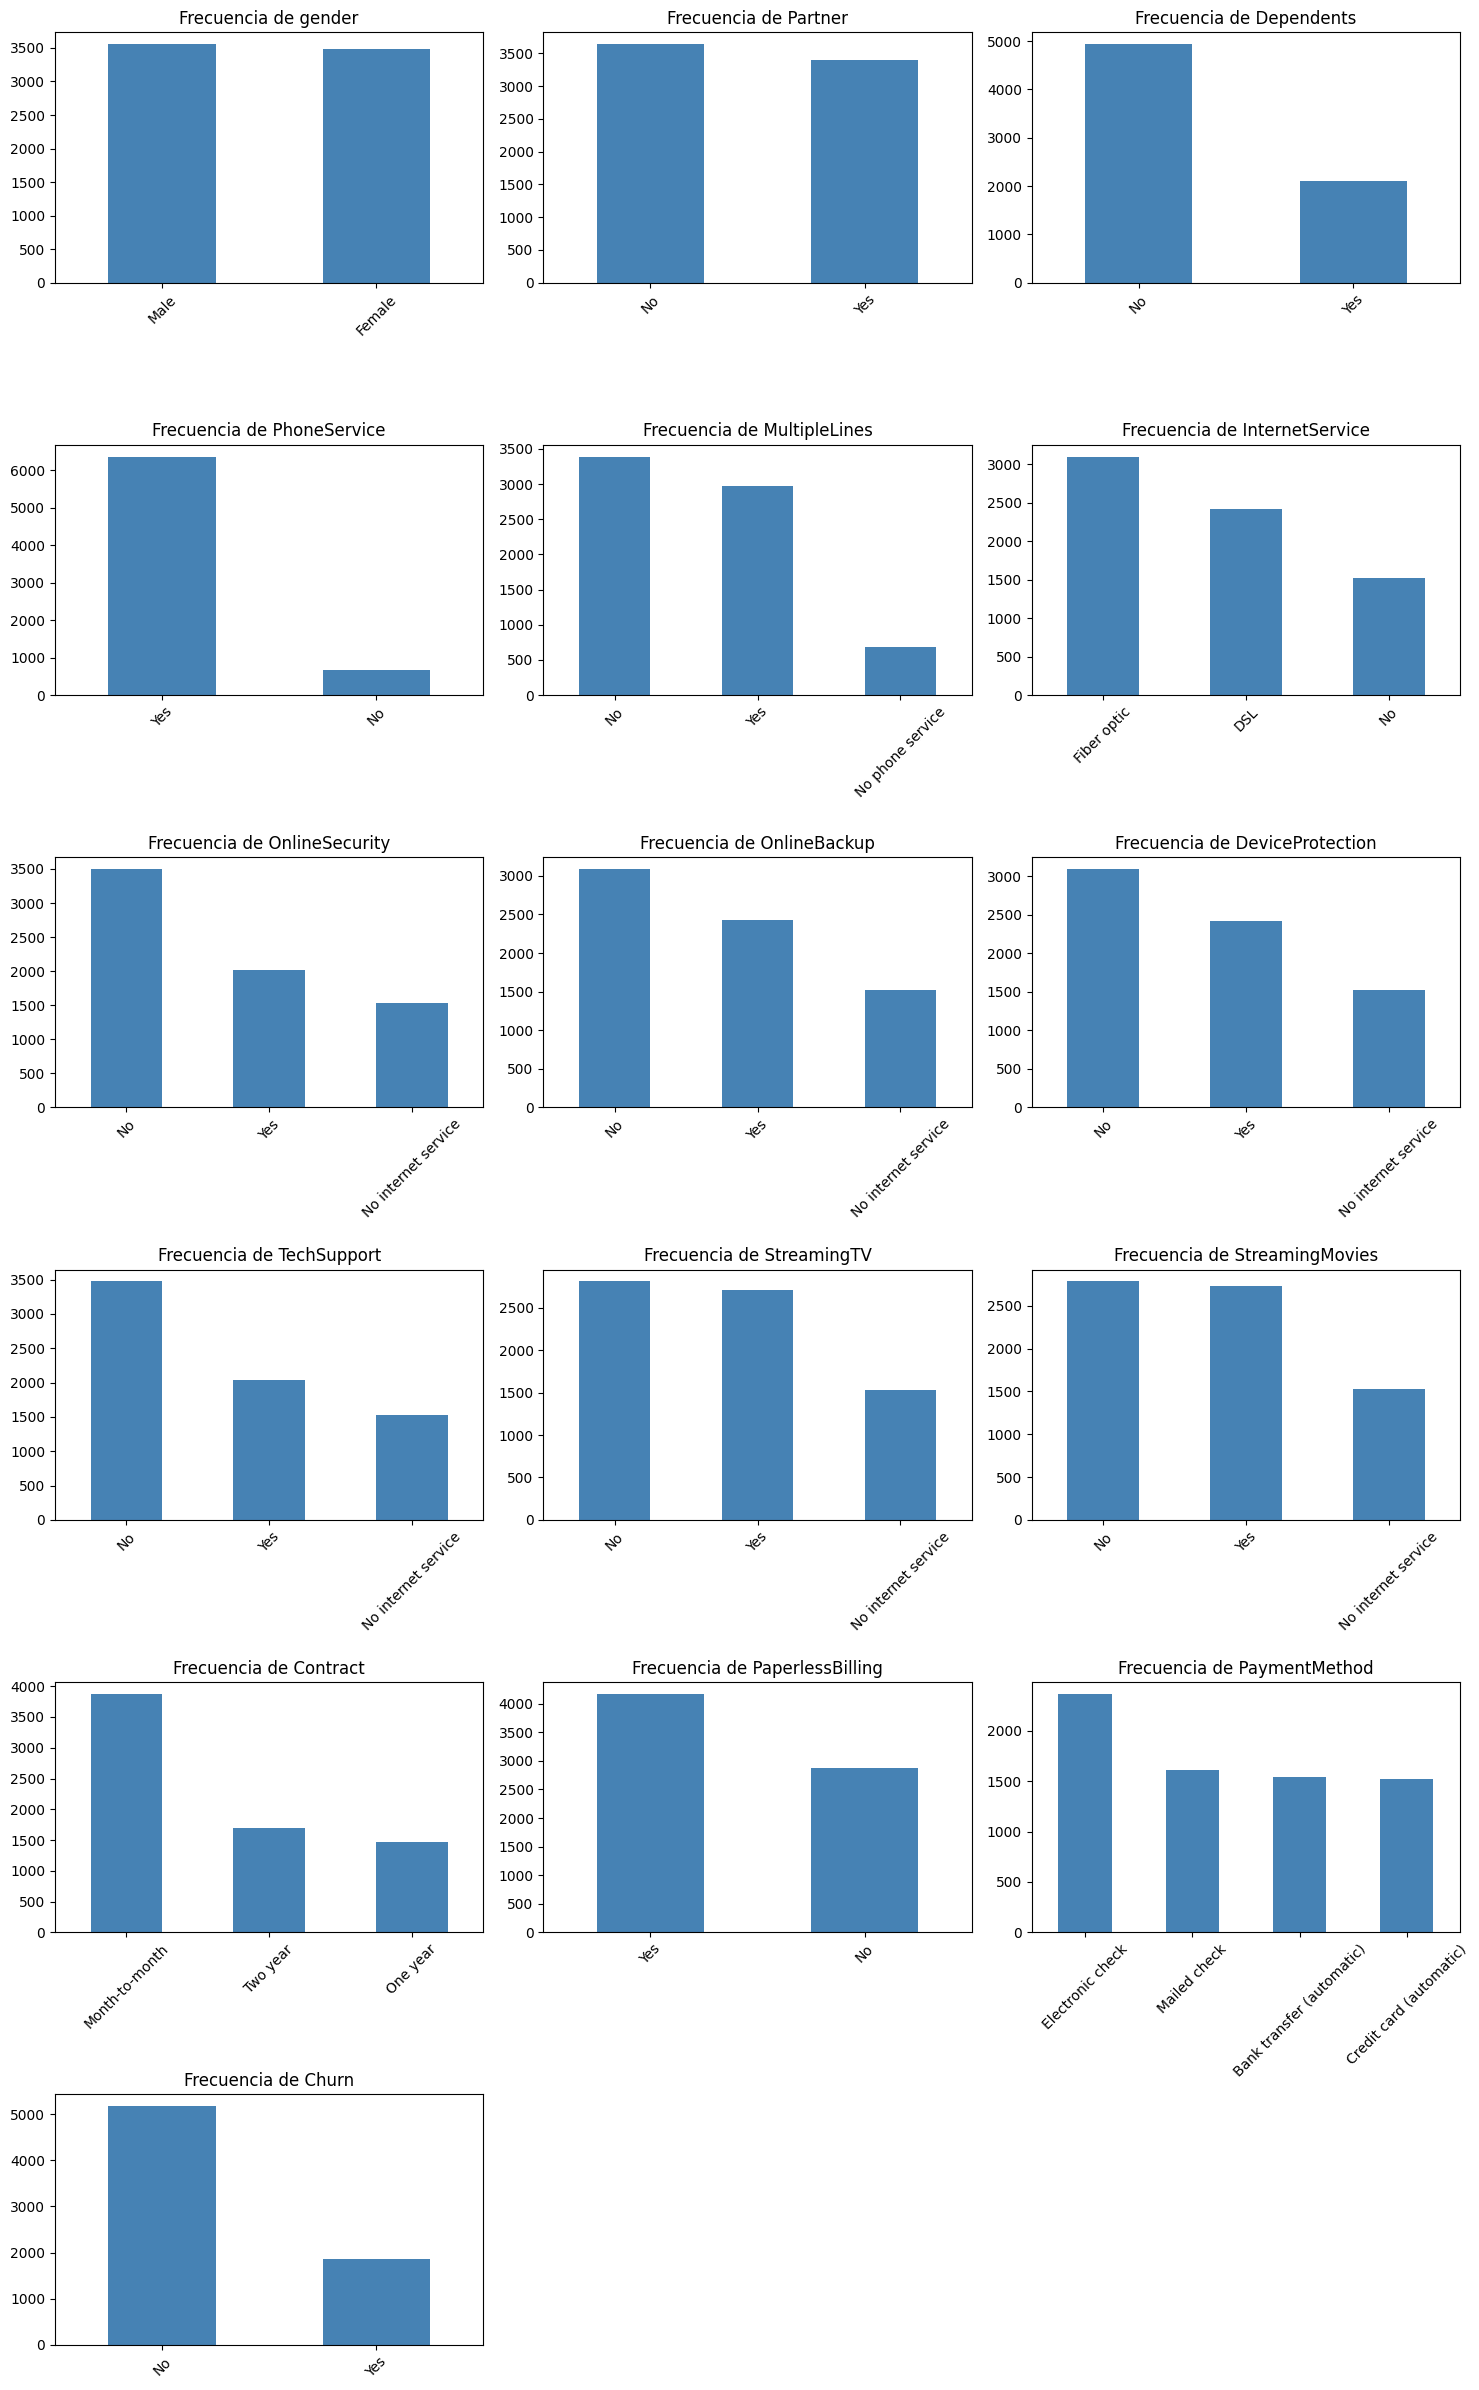

In [4]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
# Excluir customerID que no aporta
if 'customerID' in categorical_cols:
    categorical_cols.remove('customerID')

# Crear una figura con subplots (ajustar número de columnas según sea necesario)
n_cols = 3
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*4))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    df[col].value_counts().plot(kind='bar', ax=axes[i], color='steelblue')
    axes[i].set_title(f'Frecuencia de {col}')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)

# Ocultar ejes vacíos
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Proporcion global del Churn

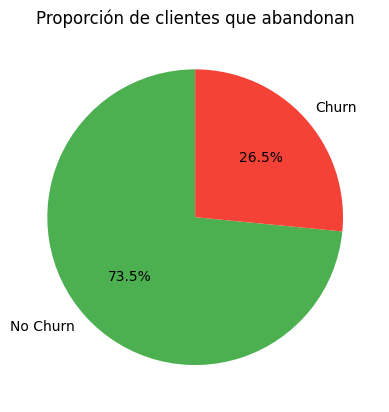

In [5]:
churn_counts = df['Churn'].value_counts()
labels = ['No Churn', 'Churn']
plt.pie(churn_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#F44336'])
plt.title('Proporción de clientes que abandonan')
plt.show()

# Relacion variables numericas

## Boxplot de tenure vs Churn

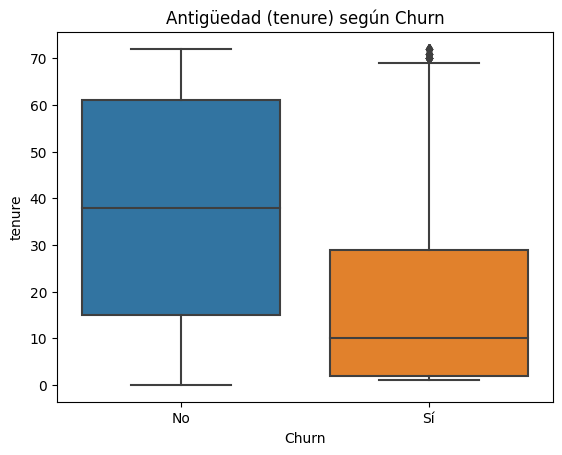

In [6]:
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Antigüedad (tenure) según Churn')
plt.xticks([0,1], ['No', 'Sí'])
plt.show()

## Boxplot de MonthlyCharges vs Churn

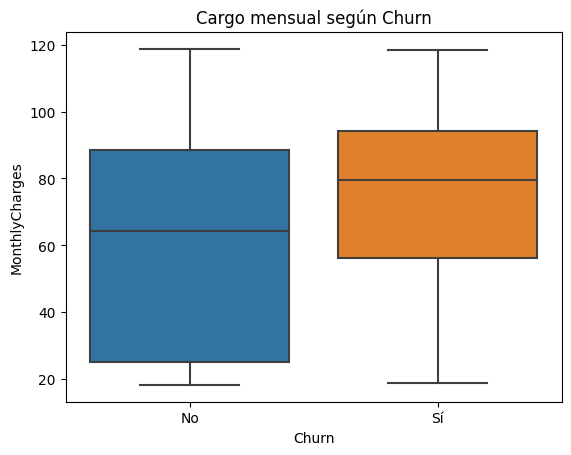

In [7]:
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Cargo mensual según Churn')
plt.xticks([0,1], ['No', 'Sí'])
plt.show()

## Bloxplot TotalChanges

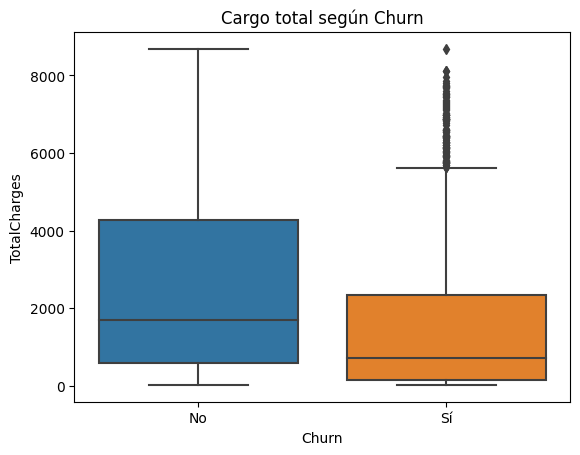

In [8]:
sns.boxplot(x='Churn', y='TotalCharges', data=df)
plt.title('Cargo total según Churn')
plt.xticks([0,1], ['No', 'Sí'])
plt.show()

# Relación entre variables categóricas y Churn

## Barras apiladas

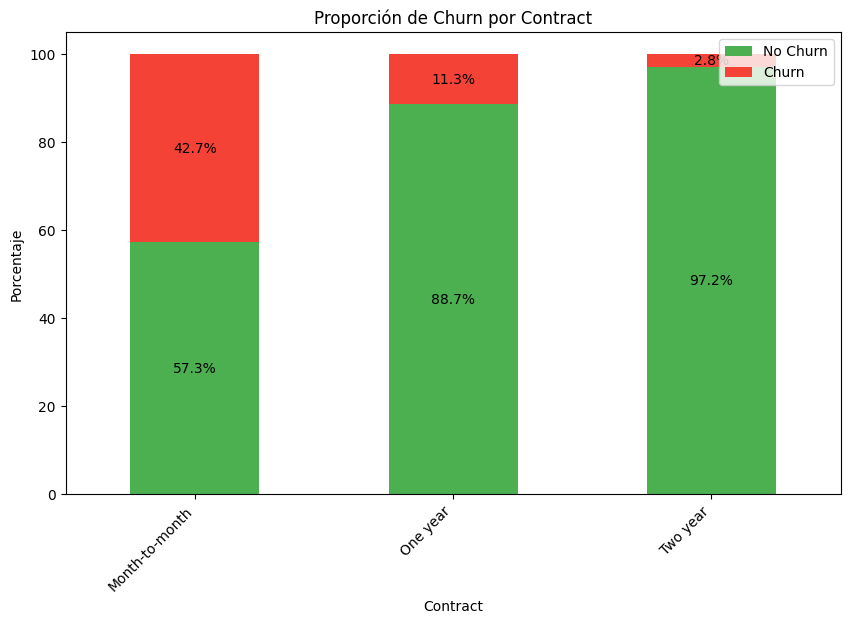

In [9]:
def plot_stacked_percentage(df, col):
    # Calcular porcentajes dentro de cada categoría
    cross = pd.crosstab(df[col], df['Churn'], normalize='index') * 100
    cross.columns = ['No Churn', 'Churn']
    ax = cross.plot(kind='bar', stacked=True, figsize=(10,6), color=['#4CAF50','#F44336'])
    plt.title(f'Proporción de Churn por {col}')
    plt.ylabel('Porcentaje')
    plt.xticks(rotation=45, ha='right')
    plt.legend(loc='upper right')
    # Añadir etiquetas con el porcentaje
    for container in ax.containers:
        ax.bar_label(container, label_type='center', fmt='%.1f%%')
    plt.show()

# Ejemplo con Contract
plot_stacked_percentage(df, 'Contract')
# Repetir para otras variables: InternetService, PaymentMethod, SeniorCitizen, etc.

# Correlaciones

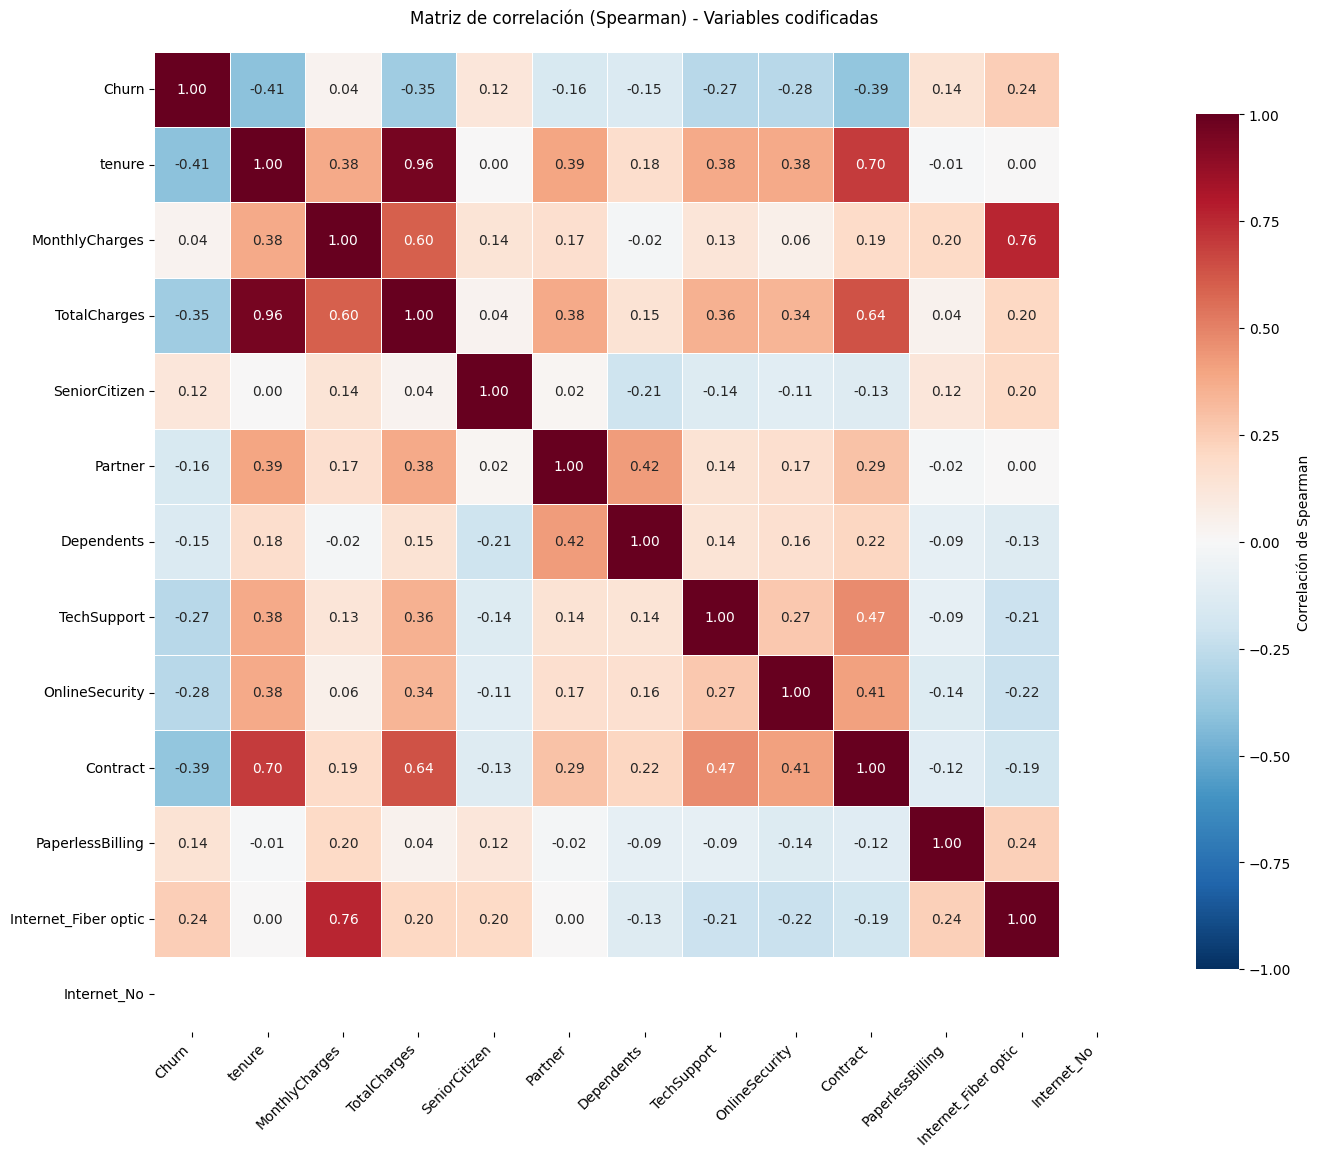

In [10]:

cols_importantes = [
    'Churn', 'tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen',
    'Partner', 'Dependents', 'InternetService', 'TechSupport',
    'OnlineSecurity', 'Contract', 'PaperlessBilling'
]

df_corr = df[cols_importantes].copy()


num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in num_cols:
    df_corr[col] = pd.to_numeric(df_corr[col], errors='coerce')


si_no = ['Churn', 'Partner', 'Dependents', 'TechSupport',
         'OnlineSecurity', 'PaperlessBilling']
for col in si_no:
    df_corr[col] = df_corr[col].map({'Yes': 1, 'No': 0})


df_corr['SeniorCitizen'] = pd.to_numeric(df_corr['SeniorCitizen'], errors='coerce')

# --- 4. Contract (ordinal) ---
df_corr['Contract'] = df_corr['Contract'].map({
    'Month-to-month': 0,
    'One year': 1,
    'Two year': 2
})


internet_dummies = pd.get_dummies(df_corr['InternetService'],
                                  prefix='Internet',
                                  drop_first=True)
df_corr = pd.concat([df_corr.drop('InternetService', axis=1),
                     internet_dummies], axis=1)


df_corr = df_corr.dropna()


corr = df_corr.corr(method='spearman')

# --- 8. Visualizar ---
plt.figure(figsize=(14, 12))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, square=True, linewidths=0.5,
            cbar_kws={'shrink': 0.8, 'label': 'Correlación de Spearman'})
plt.title('Matriz de correlación (Spearman) - Variables codificadas', pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

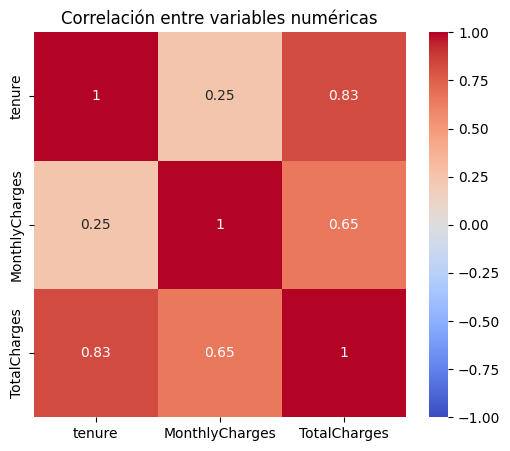

In [11]:
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')


df_clean = df[num_cols].dropna()

corr_matrix = df_clean.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlación entre variables numéricas')
plt.show()

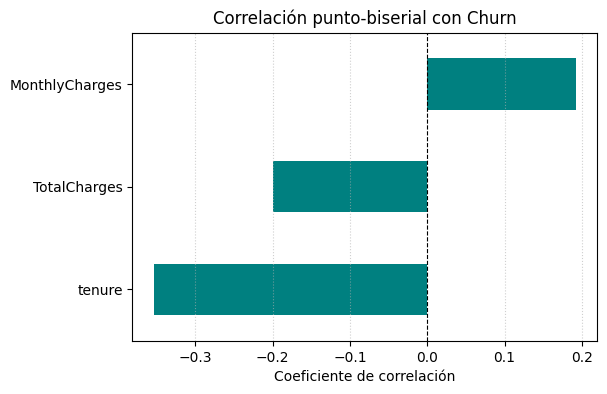

In [12]:

df['Churn_num'] = df['Churn'].map({'Yes': 1, 'No': 0})

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

df_clean = df[num_cols + ['Churn_num']].dropna()

corr_churn = df_clean[num_cols].apply(
    lambda x: x.corr(df_clean['Churn_num'])   # Pearson (punto-biserial)
).sort_values()

plt.figure(figsize=(6,4))
corr_churn.plot(kind='barh', color='teal')
plt.title('Correlación punto‑biserial con Churn')
plt.xlabel('Coeficiente de correlación')
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', linestyle=':', alpha=0.6)
plt.show()

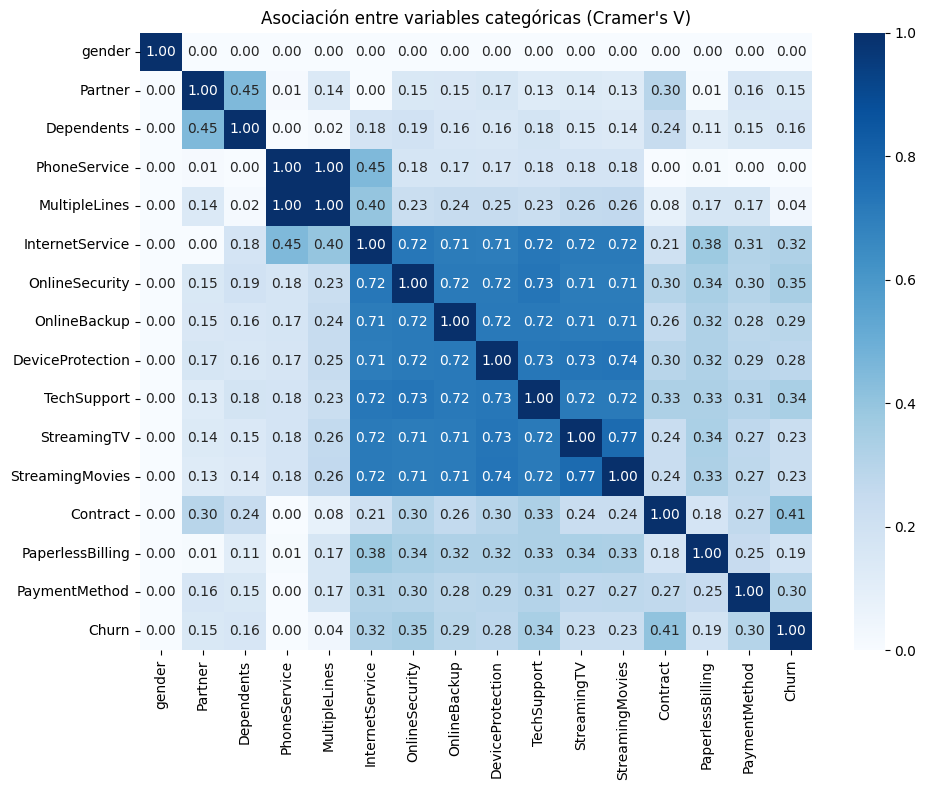

In [13]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols = [c for c in cat_cols if c != 'customerID']

n = len(cat_cols)
cramers_matrix = np.zeros((n, n))

for i, col1 in enumerate(cat_cols):
    for j, col2 in enumerate(cat_cols):
        if i == j:
            cramers_matrix[i, j] = 1.0
        else:
            ct = pd.crosstab(df[col1], df[col2])
            cramers_matrix[i, j] = cramers_v(ct)

# Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(cramers_matrix, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=cat_cols, yticklabels=cat_cols)
plt.title('Asociación entre variables categóricas (Cramer\'s V)')
plt.tight_layout()
plt.show()

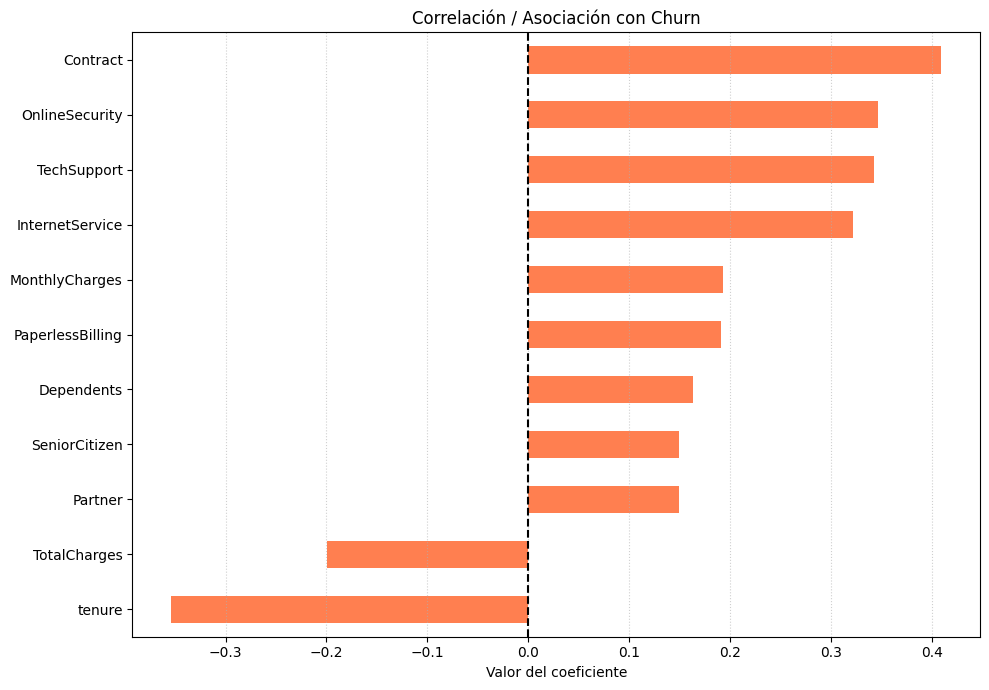

In [14]:
if 'Churn_num' not in df.columns:
    df['Churn_num'] = df['Churn'].map({'Yes': 1, 'No': 0})

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')
df_clean = df[num_cols + ['Churn_num']].dropna()


corr_dict = {}
for col in num_cols:
    corr_dict[col] = df_clean[col].corr(df_clean['Churn_num'])


def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


cat_cols = ['Partner', 'Dependents', 'InternetService', 'TechSupport',
            'OnlineSecurity', 'Contract', 'PaperlessBilling', 'SeniorCitizen']
for col in cat_cols:
    ct = pd.crosstab(df[col], df['Churn'])
    corr_dict[col] = cramers_v(ct)


corr_series = pd.Series(corr_dict).sort_values()
plt.figure(figsize=(10, 7))
corr_series.plot(kind='barh', color='coral')
plt.title('Correlación / Asociación con Churn')
plt.xlabel('Valor del coeficiente')
plt.axvline(0, color='black', linestyle='--')
plt.grid(axis='x', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()